# Commmunity Analysis

### Importing libraries

In [2]:
import networkx as nx
import numpy as np
from networkx.algorithms.community.quality import modularity
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx
import re


First, we will inspect the network

### Loading the graph

In [3]:
# Load graph and make undirected
G = nx.read_graphml("data/world_graph_attributes.graphml")
G = G.to_undirected()

In [4]:
print(len(G.nodes()))
for node, data in G.nodes(data=True):
    print(node, data)

192
Afghanistan {'sentiment_score': 2.6, 'continent': 'Asia', 'gdp': 502.115, 'official_language': 'Pashto'}
China {'sentiment_score': 5.4, 'continent': 'Asia', 'gdp': 14244.678, 'official_language': 'Standard Chinese'}
Egypt {'sentiment_score': 4.1, 'continent': 'Africa', 'gdp': 3020.031, 'official_language': 'Modern Standard Arabic'}
France {'sentiment_score': 5.5, 'continent': 'Europe', 'gdp': 40493.929, 'official_language': 'French'}
Germany {'sentiment_score': 5.0, 'continent': 'Europe', 'gdp': 46258.878, 'official_language': 'German'}
India {'sentiment_score': 6.1, 'continent': 'Asia', 'gdp': 1910.836, 'official_language': 'Hindi'}
Iran {'sentiment_score': 5.0, 'continent': 'Asia', 'gdp': 5371.177, 'official_language': 'Persian'}
Italy {'sentiment_score': 6.0, 'continent': 'Europe', 'gdp': 33189.566, 'official_language': 'Italian'}
Pakistan {'sentiment_score': 5.0, 'continent': 'Asia', 'gdp': 1405.581, 'official_language': 'Urdu'}
Qatar {'sentiment_score': 6.4, 'continent': 'Asia

### Forming Louvain Communities

In [5]:
# Building the Louvain partition using NetworkX's built-in function (define a seed for reproducibility)
louvain_communities = nx.community.louvain_communities(G, seed = 10)
print(f"Total communities formed using Louvain method: {len(louvain_communities)}\n")


for i, community in enumerate(louvain_communities):
    print(f"Louvain Community {i+1} (n = {len(community)}): {list(community)[:5]}")
print("---")

Total communities formed using Louvain method: 5

Louvain Community 1 (n = 23): ['Qatar', 'Algeria', 'Mauritania', 'Egypt', 'Morocco']
Louvain Community 2 (n = 34): ['Uruguay', 'Costa_Rica', 'Argentina', 'Colombia', 'Brazil']
Louvain Community 3 (n = 51): ['Uganda', 'Zambia', 'Tanzania', 'Kenya', 'Belgium']
Louvain Community 4 (n = 46): ['Greece', 'Sweden', 'Kazakhstan', 'Montenegro', 'Luxembourg']
Louvain Community 5 (n = 38): ['Cambodia', 'Bangladesh', 'Micronesia', 'Kiribati', 'North_Korea']
---


# Communities by attribute partitions

In [6]:
def classify_nodes_by_attribute(G, attribute, k=3):
    """
    Returns a dictionary mapping class_label -> list_of_nodes.
    The attribute has a higher value in the the higher levels.
    """

    # Collect values only from nodes that have the attribute (can be erased once the network is perfect)
    #values = []
    #nodes_with_attr = []
#
    #for n, data in G.nodes(data=True):
    #    if attribute not in data:
    #        print(f"Node '{n}' is missing attribute '{attribute}' — skipping.")
    #        continue
#
    #    # Extract attribute values
    #    values.append(data[attribute])
    #    nodes_with_attr.append(n)

    # Store the values
    #vals = np.array(values)
    vals = np.array([G.nodes[n][attribute] for n in G.nodes])

    #Use log to colapse the scale 
    vals = np.log(vals + 1) 

    # Compute partition boundaries
    bins = np.linspace(vals.min(), vals.max(), k + 1)

    # Create labels: Level_1, Level_2, ..., Level_k
    labels = [f"Level_{i+1}" for i in range(k)]

    # Prepare output dictionary
    classes = {label: [] for label in labels}

    # Assign nodes to classes
    for node, data in G.nodes(data=True):
        value = data.get(attribute)

        # Skip if missing
        if value is None:
            print(f"Node {node} has no attribute '{attribute}'")
            continue

        # Determine the partition index
        idx = np.digitize(value, bins) - 1 
        # clamp to valid range 
        idx = min(max(idx, 0), k-1)        

        classes[labels[idx]].append(node)

    return classes


In [7]:
def classify_nodes_by_attribute(G, attribute, k=3):
    """
    Classify countries into k levels based on the log of the attribute.
    """
    # extract attribute values
    vals = []
    for n in G.nodes:
        if attribute in G.nodes[n]:
            vals.append(G.nodes[n][attribute])

    vals = np.array(vals)

    # log-transform
    log_vals = np.log(vals + 1)

    # compute bins on log scale
    bins = np.linspace(log_vals.min(), log_vals.max(), k + 1)

    labels = [f"Level_{i+1}" for i in range(k)]
    classes = {label: [] for label in labels}

    # Assign nodes to classes
    for node, data in G.nodes(data=True):
        value = data.get(attribute)

        if value is None:
            print(f"Node {node} has no attribute '{attribute}'")
            continue

        # log-transform the node value too
        log_value = np.log(value + 1)

        idx = np.digitize(log_value, bins) - 1
        idx = min(max(idx, 0), k - 1)

        classes[labels[idx]].append(node)

    return classes


### Forming communities by language

Now we will try to form communities based on language. Does not work now with the new network (does not have language). 

In [8]:
# ...existing code...
from collections import defaultdict
language_communities = defaultdict(list)

for node, data in G.nodes(data=True):
    language = data.get("official_language")
    if language is None:
        # optional: collect missing nodes for inspection
        # missing_language_nodes.append(node)
        continue
    language_communities[language].append(node)

# convert to list of sets (what modularity expects)
language_partitions = [set(nodes) for nodes in language_communities.values()]


### Forming communities by continent

In [9]:
CONTINENTS = {
    "Africa": [
        "Algeria","Angola","Benin","Botswana","Burkina_Faso","Burundi",
        "Cameroon","Cape_Verde","Central_African_Republic","Chad","Comoros",
        "Congo","Democratic_Republic_of_the_Congo","Djibouti","Egypt",
        "Equatorial_Guinea","Eritrea","Eswatini","Ethiopia","Gabon",
        "Gambia","Ghana","Guinea","Guinea-Bissau","Ivory_Coast","Kenya",
        "Lesotho","Liberia","Libya","Madagascar","Malawi","Mali",
        "Mauritania","Mauritius","Morocco","Mozambique","Namibia","Niger",
        "Nigeria","Republic_of_the_Congo","Rwanda","São_Tomé_and_Príncipe",
        "Senegal","Seychelles","Sierra_Leone","Somalia","South_Africa",
        "South_Sudan","Sudan","Tanzania","The_Gambia","Togo","Tunisia",
        "Uganda","Zambia","Zimbabwe"
    ],

    "Asia": [
        "Afghanistan","Armenia","Azerbaijan","Bahrain","Bangladesh",
        "Bhutan","Brunei","Cambodia","China","Cyprus","Georgia","India",
        "Indonesia","Iran","Iraq","Israel","Japan","Jordan","Kazakhstan",
        "Kuwait","Kyrgyzstan","Laos","Lebanon","Malaysia","Maldives",
        "Mongolia","Myanmar","Nepal","North_Korea","Oman","Pakistan",
        "Philippines","Qatar","Saudi_Arabia","Singapore","South_Korea",
        "Sri_Lanka","Syria","Tajikistan","Thailand","Timor-Leste",
        "Turkey","Turkmenistan","United_Arab_Emirates","Uzbekistan",
        "Vietnam","Yemen"
    ],

    "Europe": [
        "Albania","Andorra","Austria","Belarus","Belgium","Bosnia_and_Herzegovina",
        "Bulgaria","Croatia","Czech_Republic","Denmark","Estonia","Finland",
        "France","Germany","Greece","Hungary","Iceland","Ireland","Italy",
        "Kazakhstan","Kosovo","Latvia","Liechtenstein","Lithuania","Luxembourg",
        "Malta","Moldova","Monaco","Montenegro","Netherlands","North_Macedonia",
        "Norway","Poland","Portugal","Romania","Russia","San_Marino","Serbia",
        "Slovakia","Slovenia","Spain","Sweden","Switzerland","Ukraine",
        "United_Kingdom"
    ],

    "North_America": [
        "Antigua_and_Barbuda","Bahamas","Barbados","Belize","Canada","Costa_Rica",
        "Cuba","Dominica","Dominican_Republic","El_Salvador","Grenada","Guatemala",
        "Haiti","Honduras","Jamaica","Mexico","Nicaragua","Panama",
        "Saint_Kitts_and_Nevis","Saint_Lucia","Saint_Vincent_and_the_Grenadines",
        "The_Bahamas","Trinidad_and_Tobago","United_States"
    ],

    "South_America": [
        "Argentina","Bolivia","Brazil","Chile","Colombia","Ecuador","Guyana",
        "Paraguay","Peru","Suriname","Uruguay","Venezuela"
    ],

    "Oceania": [
        "Australia","Fiji","Kiribati","Marshall_Islands","Micronesia","Nauru",
        "New_Zealand","Palau","Papua_New_Guinea","Samoa","Solomon_Islands",
        "Tonga","Tuvalu","Vanuatu"
    ]
}
# create continent partitions similar to GDP partitions

continent_communities = defaultdict(list)

for node, data in G.nodes(data=True):
    continent = data.get("continent")
    if continent is None:
        # optional: collect missing nodes for inspection
        # missing_language_nodes.append(node)
        continue
    continent_communities[continent].append(node)

# convert to list of sets (what modularity expects)
continent_partitions = [set(nodes) for nodes in continent_communities.values()]

### Forming community by GDP

In [10]:
gdp_partitions = classify_nodes_by_attribute(G,'gdp', k=3)

In [11]:
print(len(gdp_partitions["Level_1"]), "elements")
print(len(gdp_partitions["Level_1"]))

55 elements
55


In [12]:
print(len(gdp_partitions["Level_2"]), "elements")
print(len(gdp_partitions["Level_2"]))

97 elements
97


In [13]:
print(len(gdp_partitions["Level_3"]))

40


### Forming communities by History Sentiment Score

In [14]:
sentiment_partitions = classify_nodes_by_attribute(G, "sentiment_score", k=3)

In [15]:
print(len(sentiment_partitions["Level_1"]), "elements")
sentiment_partitions["Level_1"][:5] # TO SHOW


12 elements


['Afghanistan', 'Mali', 'Yemen', 'Democratic_Republic_of_the_Congo', 'Burundi']

In [16]:
print(len(sentiment_partitions["Level_2"]), "elements")
sentiment_partitions["Level_2"][:5] # TO SHOW

95 elements


['Egypt', 'Germany', 'Iran', 'Pakistan', 'Russia']

In [17]:
print(len(sentiment_partitions["Level_2"]), "elements")
sentiment_partitions["Level_3"][:5] # TO SHOW

95 elements


['China', 'France', 'India', 'Italy', 'Qatar']

# Analysing the communities

### Calculating the Modularity of the different partitions

Modularity (GDP partitions): 0.0858
Total communities formed using GDP partitions: 3

Modularity (Sentiment partitions): 0.0281
Total communities formed using Sentiment partitions: 3

Modularity (Louvain communities): 0.3660
Total communities formed using Louvain method: 5

Modularity (Continent partitions): 0.3032
Total communities formed using Continent partitions: 6

Modularity (Language partitions): 0.1121
Total communities formed using Language partitions: 81



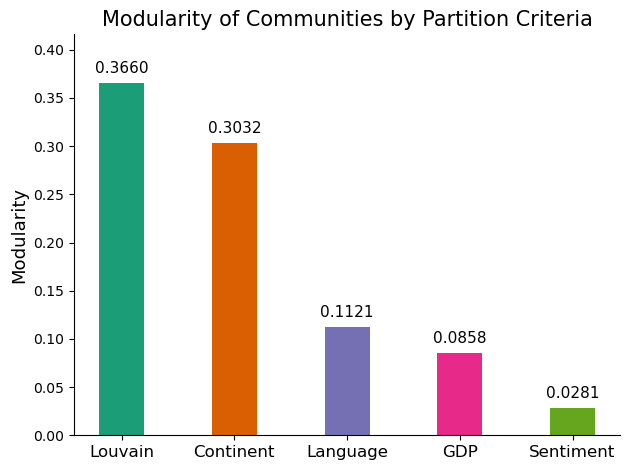

In [18]:
# Calculate modularity for GDP partitions
gdp_modularity = modularity(G, gdp_partitions.values())
print(f"Modularity (GDP partitions): {gdp_modularity:.4f}")
# PRINT NUMBER OF COMMUNITIES IN GDP PARTITIONS
print(f"Total communities formed using GDP partitions: {len(gdp_partitions)}\n")

# Calculate modularity for sentiment partitions
sentiment_modularity = modularity(G, sentiment_partitions.values())
print(f"Modularity (Sentiment partitions): {sentiment_modularity:.4f}")
# PRINT NUMBER OF COOMUNITIES IN SENTIMENT PARTITIONS
print(f"Total communities formed using Sentiment partitions: {len(sentiment_partitions)}\n")

# Calculate modularity for Louvain communities
louvain_modularity = modularity(G, louvain_communities)
print(f"Modularity (Louvain communities): {louvain_modularity:.4f}")
# PRINT NUMBER OF COMMUNITIES IN LOUVAIN METHOD
print(f"Total communities formed using Louvain method: {len(louvain_communities)}\n")

# Continent partitions modularity
continent_modularity = modularity(G, continent_partitions)
print(f"Modularity (Continent partitions): {continent_modularity:.4f}")
# PRINT NUMBER OF COMMUNITIES IN CONTINENT PARTITIONS
print(f"Total communities formed using Continent partitions: {len(continent_partitions)}\n")

# Language partitions modularity
language_modularity = modularity(G, language_partitions)
print(f"Modularity (Language partitions): {language_modularity:.4f}")
# PRINT NUMBER OF COMMUNITIES IN LANGUAGE PARTITIONS
print(f"Total communities formed using Language partitions: {len(language_partitions)}\n")

# Plot the modularity values for comparison with improved colors
labels = ['Louvain', 'Continent', 'Language', 'GDP', 'Sentiment']
modularity_values = [louvain_modularity, continent_modularity, language_modularity, gdp_modularity, sentiment_modularity]
x = np.arange(len(labels))
width = 0.4

# Use more distinct and colorblind-friendly colors
bar_colors = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e']

fig, ax = plt.subplots()
bars = ax.bar(x, modularity_values, width, color=bar_colors, linewidth=1.2)
ax.set_ylabel('Modularity', fontsize=13)
ax.set_title('Modularity of Communities by Partition Criteria', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.set_ylim(0, max(modularity_values) + 0.05)

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=11)

sns.despine()
plt.tight_layout()
plt.show()


### Visualizing the commmunity graphs

Visualizing the communities for all partitions...



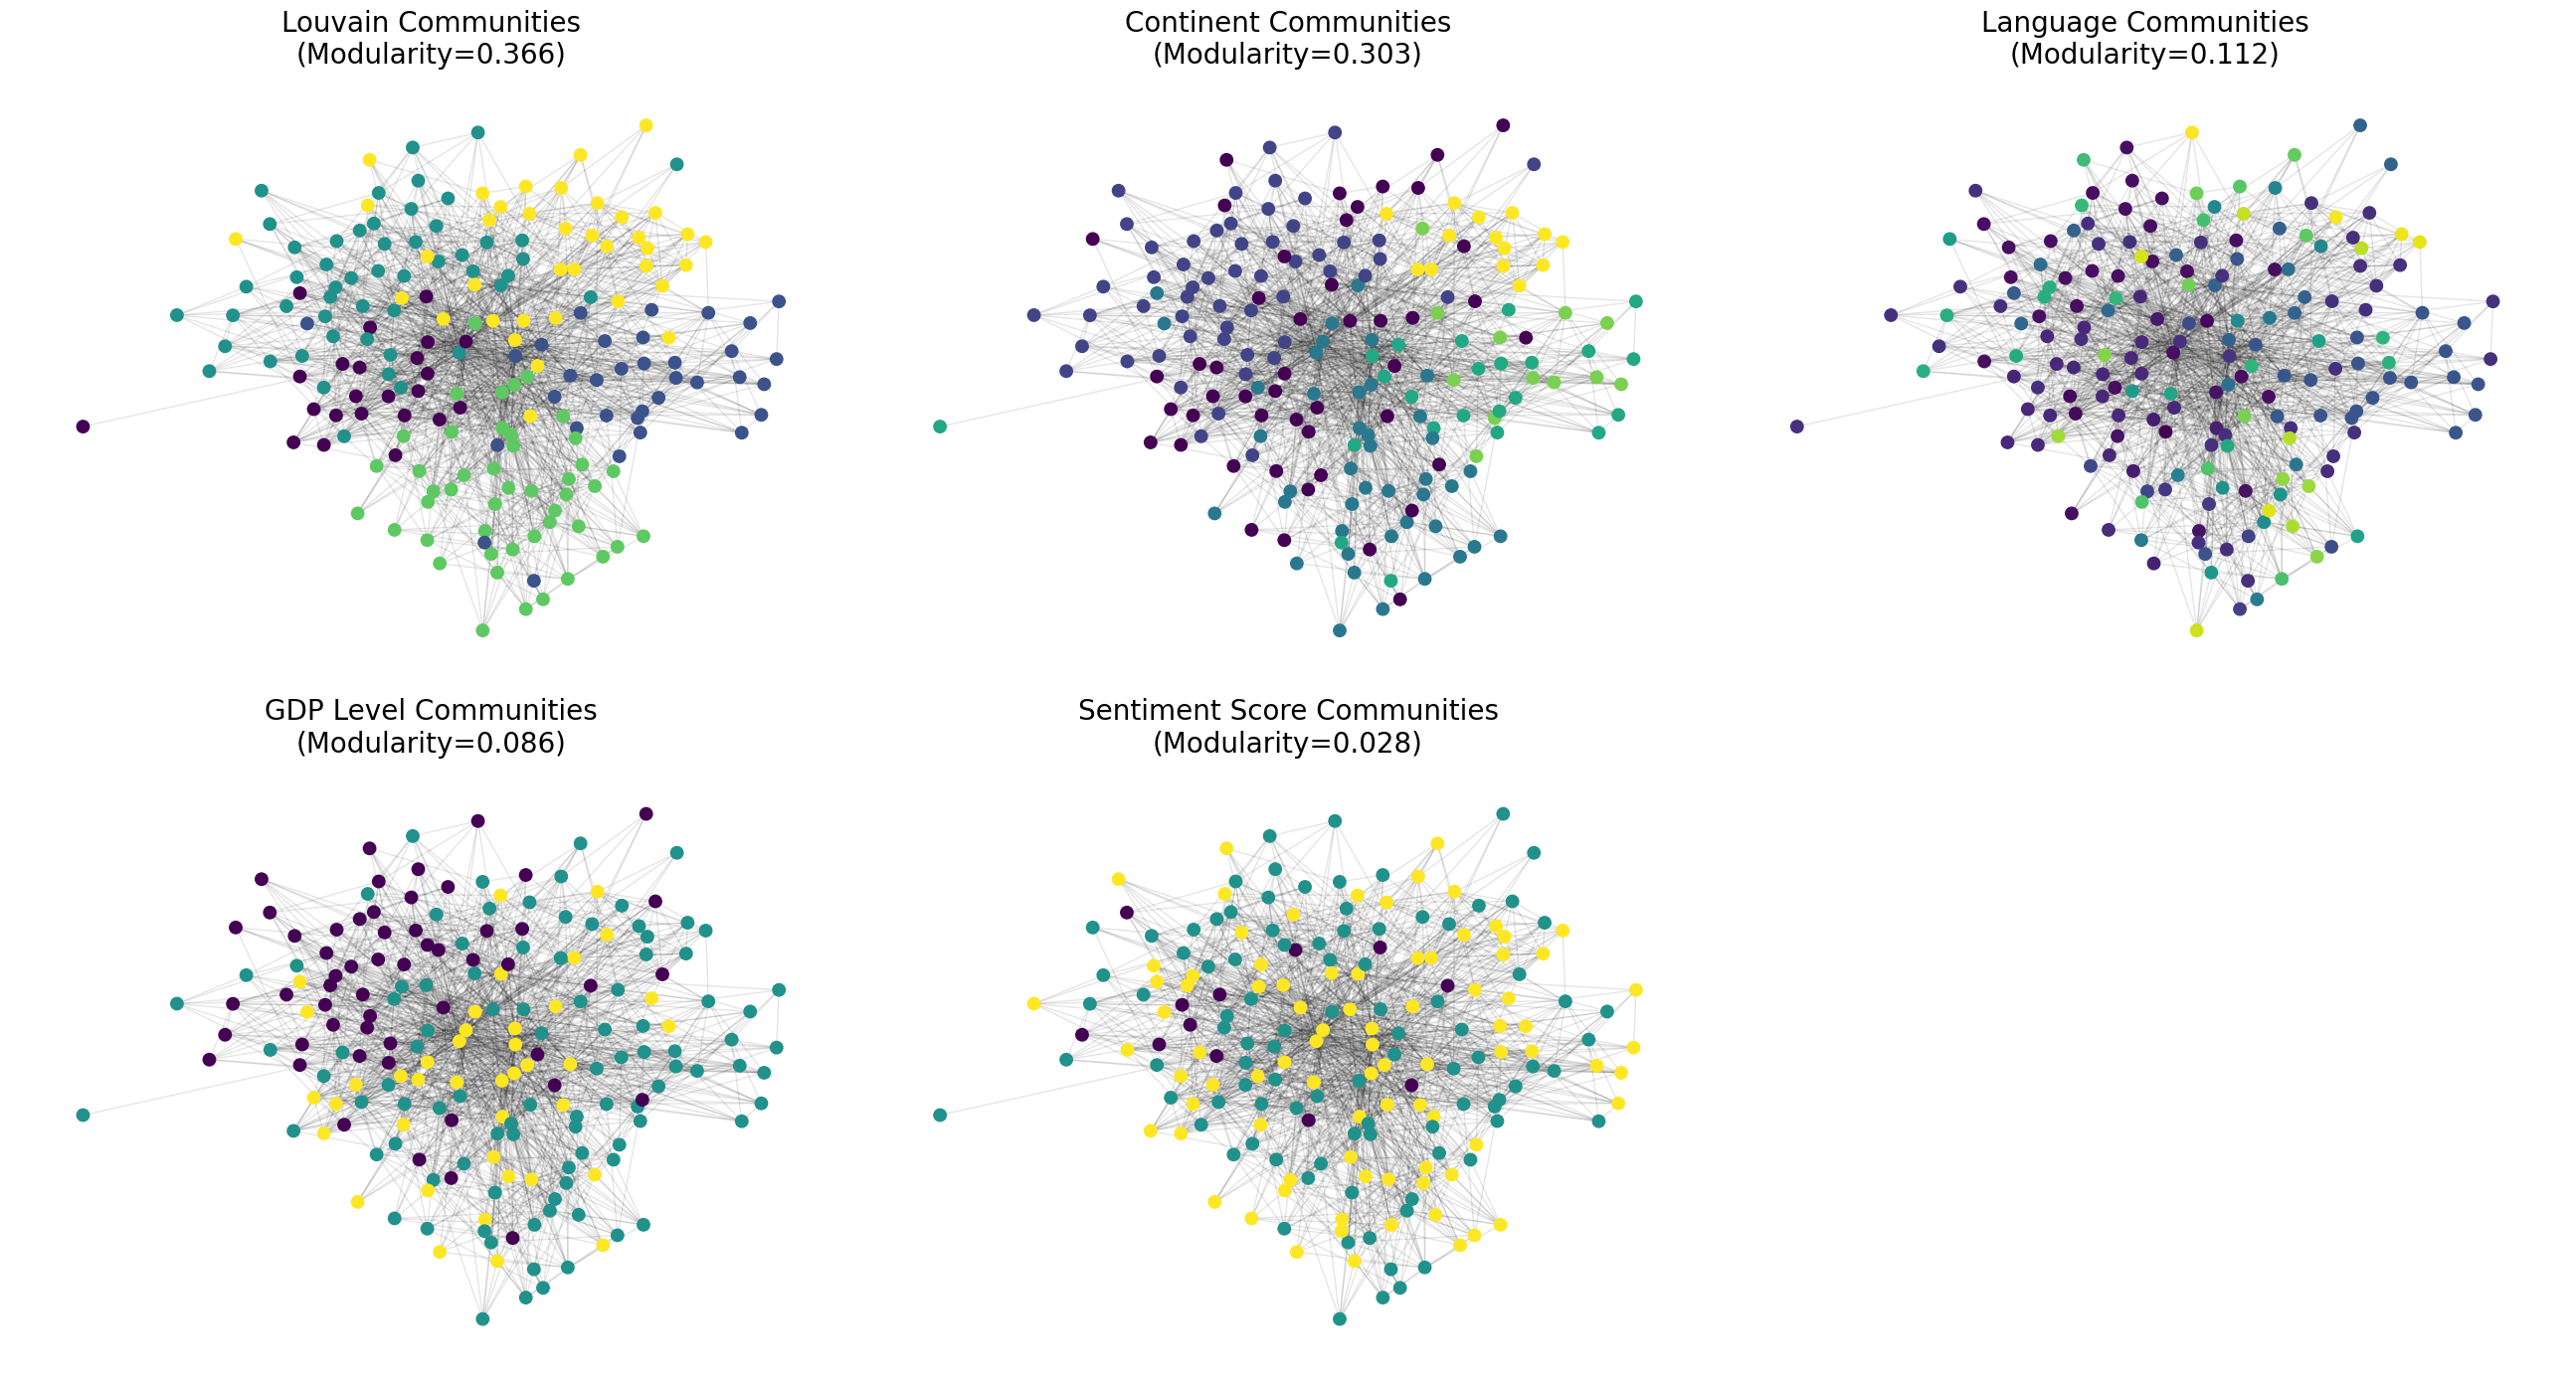

In [19]:
print("Visualizing the communities for all partitions...\n")

fig, axes = plt.subplots(2, 3, figsize=(26, 14))
axes = axes.flatten()
pos = nx.spring_layout(G, seed=42)

def partition_to_colors(G, partitions):
    """Map each node to an integer color index based on its partition."""
    groups = list(partitions.values())
    return [
        next(i for i, group in enumerate(groups) if node in group)
        for node in G.nodes()
    ]

# Map partitions to colors
colors_map = [
    ("Louvain Communities",          louvain_colors := partition_to_colors(G, {i:c for i, c in enumerate(louvain_communities)}), louvain_modularity),
    ("Continent Communities",        continent_colors := partition_to_colors(G, continent_communities), continent_modularity),
    ("Language Communities",         language_colors := partition_to_colors(G, language_communities), language_modularity),
    ("GDP Level Communities",        gdp_colors := partition_to_colors(G, gdp_partitions), gdp_modularity),
    ("Sentiment Score Communities",  sentiment_colors := partition_to_colors(G, sentiment_partitions), sentiment_modularity),
]

for ax, (title, color_list, modularity) in zip(axes, colors_map):
    ax.set_title(f"{title}\n(Modularity={modularity:.3f})", fontsize=20)
    nx.draw_networkx_nodes(G, pos, node_size=80, node_color=color_list,
                           cmap=plt.cm.viridis, ax=ax)
    nx.draw_networkx_edges(G, pos, alpha=0.1, ax=ax)
    ax.axis("off")

# Hide unused 6th subplot (if only 5 plots)
axes[-1].axis("off")

plt.tight_layout()
plt.show()




### Visualization of the Matrix _D_

Generating confusion matrices for all community factors...



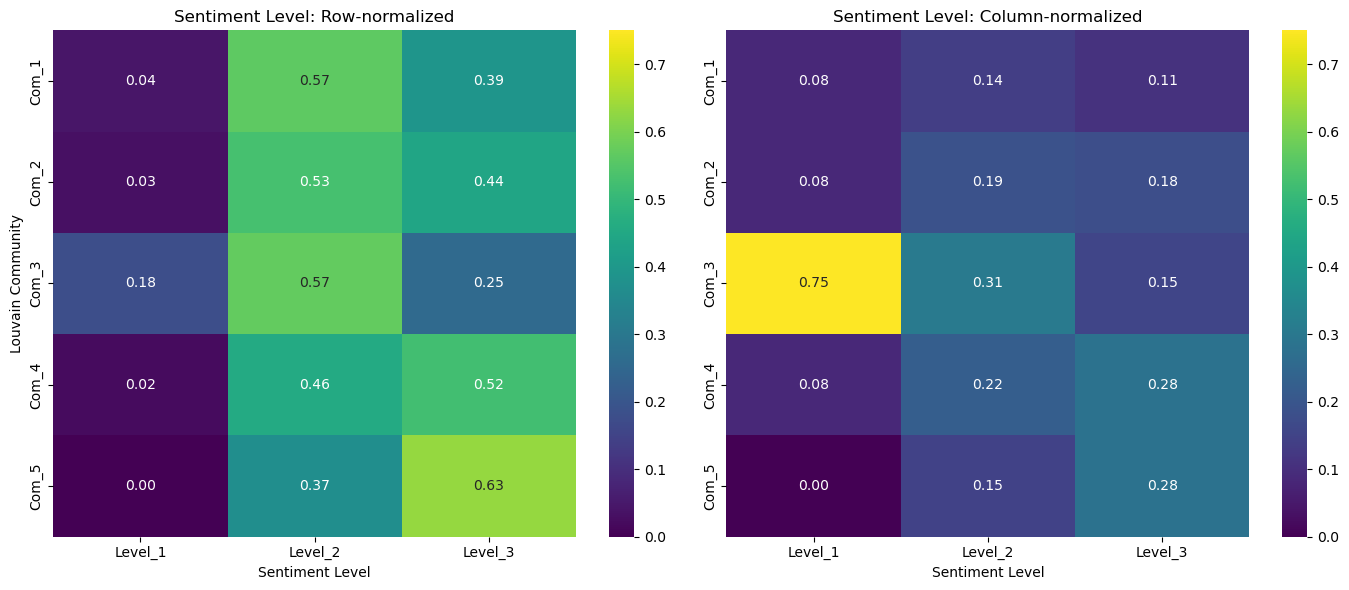

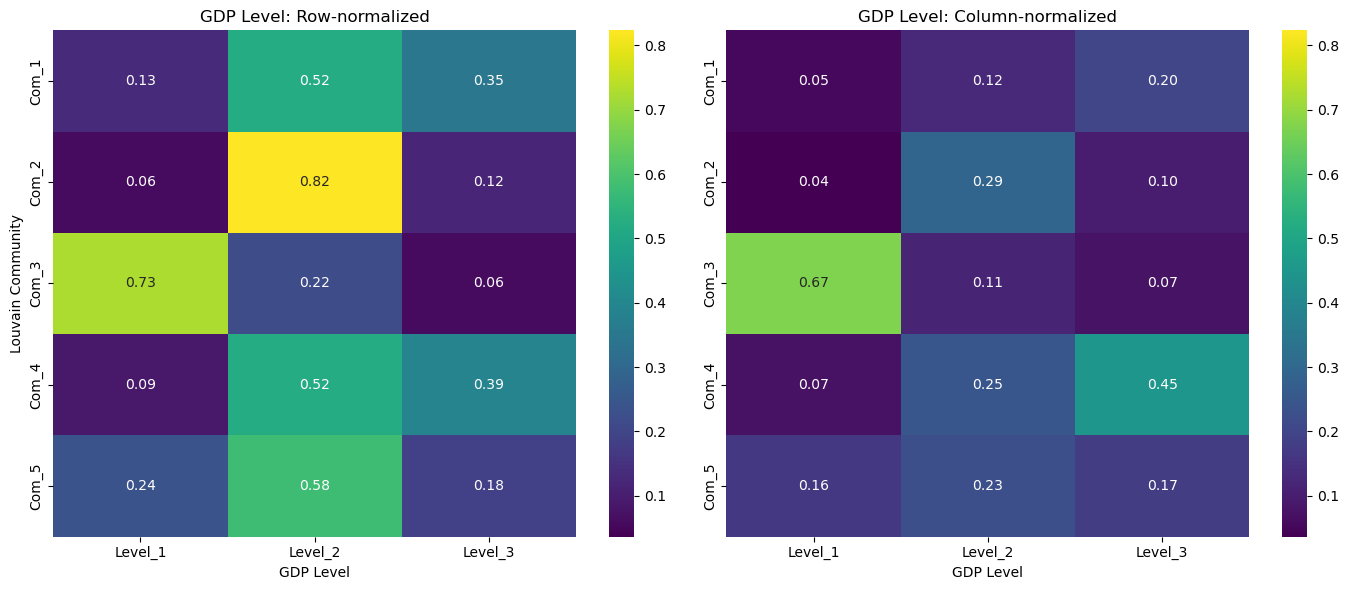

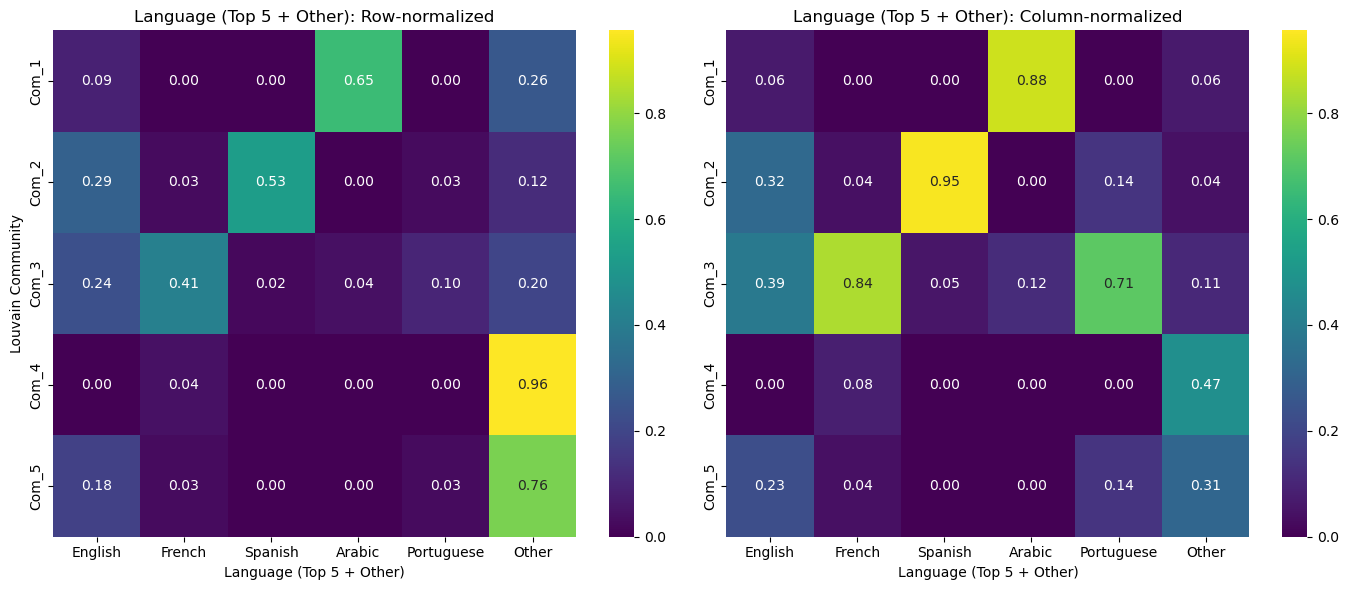

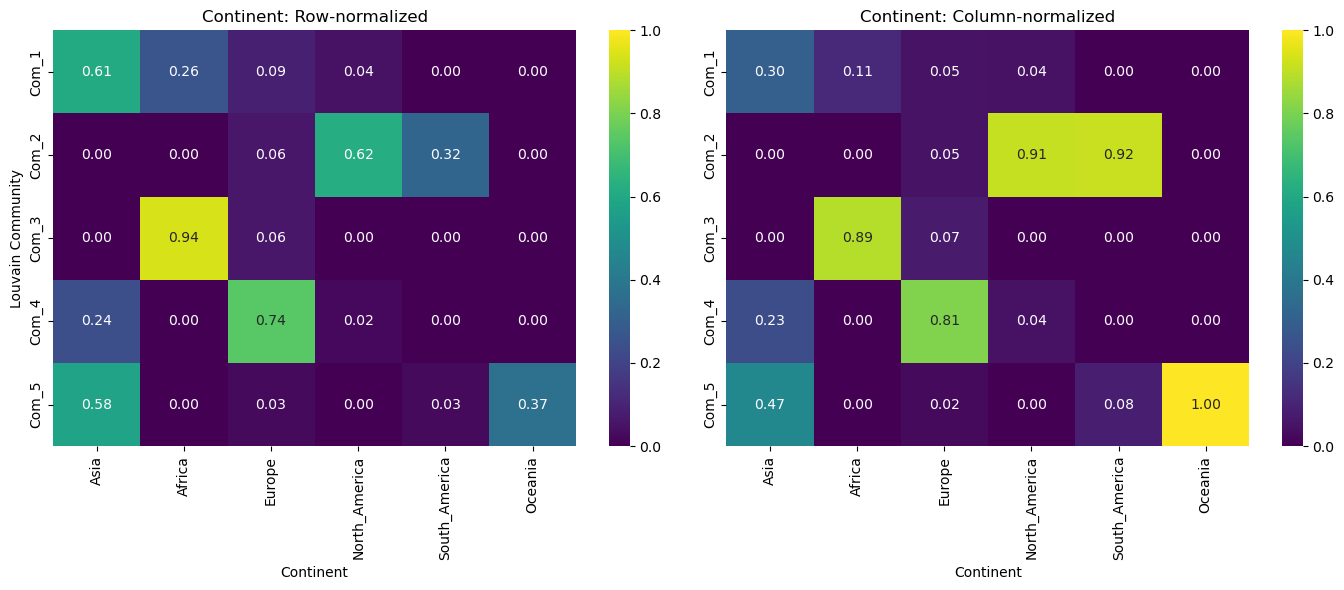

In [20]:
print("Generating confusion matrices for all community factors...\n")

def make_confusion_matrix(row_groups, col_groups):
    """
    row_groups: list of node-lists (e.g., Louvain communities)
    col_groups: dict mapping label → node-list
    """
    rows = len(row_groups)
    cols = len(col_groups)
    matrix = np.zeros((rows, cols), dtype=int)

    col_keys = list(col_groups.keys())

    for i, row_group in enumerate(row_groups):
        row_set = set(row_group)
        for j, key in enumerate(col_keys):
            col_set = set(col_groups[key])
            matrix[i, j] = len(row_set & col_set)

    return matrix, col_keys


def reduce_to_top_k(partition_dict, k=5):
    """
    Keeps top-k largest groups, merges remaining groups into 'Other'.
    partition_dict: {label → list_of_nodes}
    """
    # Sort by size
    sorted_items = sorted(partition_dict.items(), key=lambda x: len(x[1]), reverse=True)

    # Top-k
    top_k = dict(sorted_items[:k])

    # All remaining grouped together
    other_nodes = []
    for key, nodes in sorted_items[k:]:
        other_nodes.extend(nodes)

    if other_nodes:
        top_k["Other"] = other_nodes

    return top_k


def plot_normalized_matrices(matrix, row_labels, col_labels, factor_name):
    """
    Plots row-normalized and column-normalized heatmaps for a confusion matrix.
    """

    row_norm = matrix / matrix.sum(axis=1, keepdims=True)
    col_norm = matrix / matrix.sum(axis=0, keepdims=True)

    vmax = max(row_norm.max(), col_norm.max())
    vmin = min(row_norm.min(), col_norm.min())

    plt.figure(figsize=(14, 6))

    # ---- Row-normalized ----
    plt.subplot(1, 2, 1)
    sns.heatmap(
        row_norm, annot=True, fmt='.2f', cmap='viridis',
        xticklabels=col_labels, yticklabels=row_labels,
        vmin=vmin, vmax=vmax
    )
    plt.title(f"{factor_name}: Row-normalized")
    plt.xlabel(factor_name)
    plt.ylabel("Louvain Community")

    # ---- Column-normalized ----
    plt.subplot(1, 2, 2)
    sns.heatmap(
        col_norm, annot=True, fmt='.2f', cmap='viridis',
        xticklabels=col_labels, yticklabels=row_labels,
        vmin=vmin, vmax=vmax
    )
    plt.title(f"{factor_name}: Column-normalized")
    plt.xlabel(factor_name)
    plt.ylabel("")

    plt.tight_layout()
    plt.show()


# ---------------------------
# PREPROCESS: Language → Top 5 + Other
# ---------------------------

language_top5 = reduce_to_top_k(language_communities, k=5)

# ---------------------------
# FACTOR CONFIGURATION
# ---------------------------

factors = [
    ("Sentiment Level", sentiment_partitions),
    ("GDP Level",       gdp_partitions),
    ("Language (Top 5 + Other)", language_top5),
    ("Continent",       continent_communities),
]

# ---------------------------
# PLOT ALL MATRICES
# ---------------------------

for factor_name, partitions in factors:

    matrix, col_labels = make_confusion_matrix(
        louvain_communities,
        partitions
    )

    # Raw confusion matrix
    #plt.figure(figsize=(8, 6))
    #sns.heatmap(
        #matrix, annot=True, fmt="d", cmap="viridis",
        #xticklabels=col_labels,
        #yticklabels=[f"Com_{i+1}" for i in range(len(louvain_communities))]
    #)
    #plt.title(f"Confusion Matrix: Louvain Communities vs {factor_name}")
    #plt.xlabel(factor_name)
    #plt.ylabel("Louvain Community")
    #plt.tight_layout()
    #plt.show()

    # Normalized versions
    row_labels = [f"Com_{i+1}" for i in range(len(louvain_communities))]

    plot_normalized_matrices(
        matrix,
        row_labels=row_labels,
        col_labels=col_labels,
        factor_name=factor_name
    )


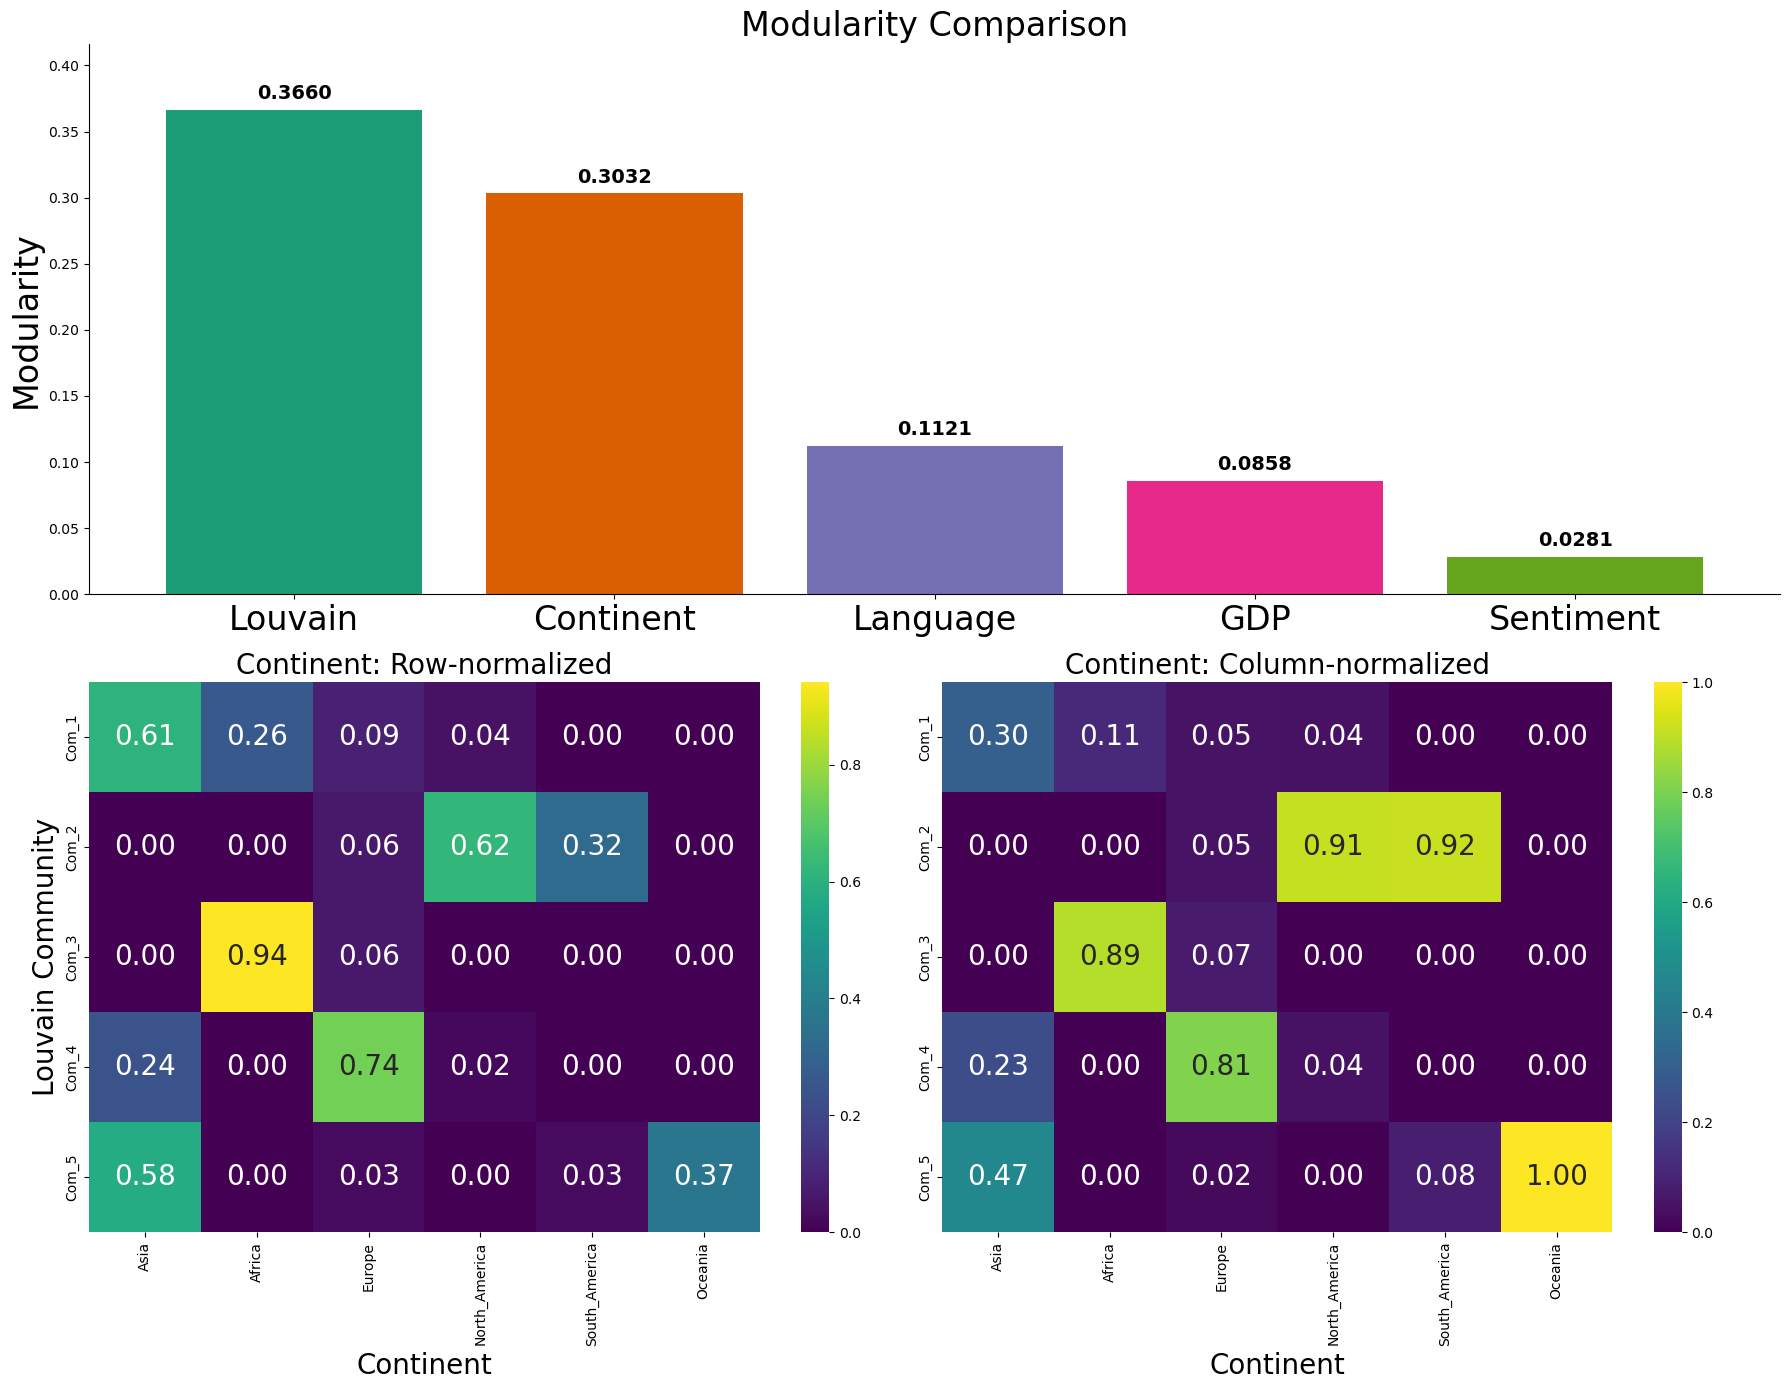

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# # Make all default fonts bigger
# plt.rcParams.update({
#     "font.size": 20,        
#     "axes.titlesize": 20,   
#     "axes.labelsize": 20,   
#     "xtick.labelsize": 20,  
#     "ytick.labelsize": 16,
# })

# --- Generate continent confusion matrix ---
matrix, col_labels = make_confusion_matrix(
    louvain_communities,
    continent_communities
)

row_labels = [f"Com_{i+1}" for i in range(len(louvain_communities))]

# Normalizations
row_norm = matrix / matrix.sum(axis=1, keepdims=True)
col_norm = matrix / matrix.sum(axis=0, keepdims=True)


fig = plt.figure(figsize=(18, 14))

# -------------------------------------------------- 
# TOP: Modularity bar chart
# -------------------------------------------------- 
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)

labels = ['Louvain', 'Continent', 'Language', 'GDP', 'Sentiment']
modularity_values = [
    louvain_modularity, continent_modularity, language_modularity,
    gdp_modularity, sentiment_modularity
]

x = np.arange(len(labels))
bar_colors = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e']

bars = ax1.bar(x, modularity_values, color=bar_colors)
ax1.set_ylabel("Modularity", fontsize=24)
ax1.set_title("Modularity Comparison", fontsize=24)
ax1.set_xticks(x)
ax1.set_xticklabels(labels, fontsize=24)
ax1.set_ylim(0, max(modularity_values) + 0.05)

for bar in bars:
    height = bar.get_height()
    ax1.annotate(
        f"{height:.4f}",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 5),
        textcoords="offset points",
        ha="center", va="bottom",
        fontsize=14, fontweight="bold"
    )

sns.despine(ax=ax1)

# -------------------------------------------------- 
# BOTTOM LEFT: Row-normalized confusion matrix
# -------------------------------------------------- 
ax2 = plt.subplot2grid((2, 2), (1, 0))

sns.heatmap(
    row_norm,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    xticklabels=col_labels,
    yticklabels=row_labels,
    ax=ax2,
    annot_kws={"size": 20}   
)

ax2.set_title("Continent: Row-normalized", fontsize=20)
ax2.set_xlabel("Continent", fontsize=20)
ax2.set_ylabel("Louvain Community", fontsize=20)

# -------------------------------------------------- 
# BOTTOM RIGHT: Column-normalized confusion matrix
# -------------------------------------------------- 
ax3 = plt.subplot2grid((2, 2), (1, 1))

sns.heatmap(
    col_norm,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    xticklabels=col_labels,
    yticklabels=row_labels,
    ax=ax3,
    annot_kws={"size": 20} 
)

ax3.set_title("Continent: Column-normalized", fontsize=20)
ax3.set_xlabel("Continent", fontsize=20)
ax3.set_ylabel("", fontsize=16)

plt.tight_layout()
plt.show()

In [22]:
import pandas as pd
import networkx as nx

# 1. Function to calculate assortativity within a specific set of nodes
def calculate_community_assortativity(graph, community_nodes, attribute='sentiment_score'):
    # Create a subgraph for just this community to analyze internal links only
    subgraph = graph.subgraph(community_nodes)
    
    # NetworkX has a built-in function for this
    # If the coefficient is negative, it means high sentiment connects to low sentiment
    try:
        return nx.numeric_assortativity_coefficient(subgraph, attribute)
    except ValueError:
        # Happens if a community is too small or has no variance
        return None

# 2. Run this for all your communities
community_stats = []

for i, community in enumerate(louvain_communities):
    # Calculate the "Conflict Score" (Assortativity)
    assortativity = calculate_community_assortativity(G, community)
    
    # Calculate average sentiment just for context
    avg_sentiment = np.mean([G.nodes[n].get('sentiment_score', 0) for n in community])
    
    community_stats.append({
        'Community_ID': i + 1,
        'Assortativity': assortativity, # Negative values = Conflicting History
        'Size': len(community),
        'Avg_Sentiment': avg_sentiment
    })

# 3. View the results
df_conflict = pd.DataFrame(community_stats)

# Sort by Assortativity (Ascending) because distinct Negative values show the strongest conflict
print("Communities with the most 'Conflicting' connections (Negative Assortativity):")
print(df_conflict.sort_values(by='Assortativity').head())

Communities with the most 'Conflicting' connections (Negative Assortativity):
   Community_ID  Assortativity  Size  Avg_Sentiment
0             1      -0.072362    23       5.052174
1             2      -0.057752    34       4.950000
4             5      -0.023962    38       5.244737
2             3       0.007495    51       4.468627
3             4       0.155462    46       5.358696


Most Conflicted Communities (by Sentiment Standard Deviation):
Community
4    1.073225
3    0.952573
2    0.907294
1    0.871712
5    0.773094
Name: Sentiment, dtype: float64


C:\Users\Maria\AppData\Local\Temp\ipykernel_8884\2554655826.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_analysis, x='Community', y='Sentiment', inner="stick", palette="viridis")


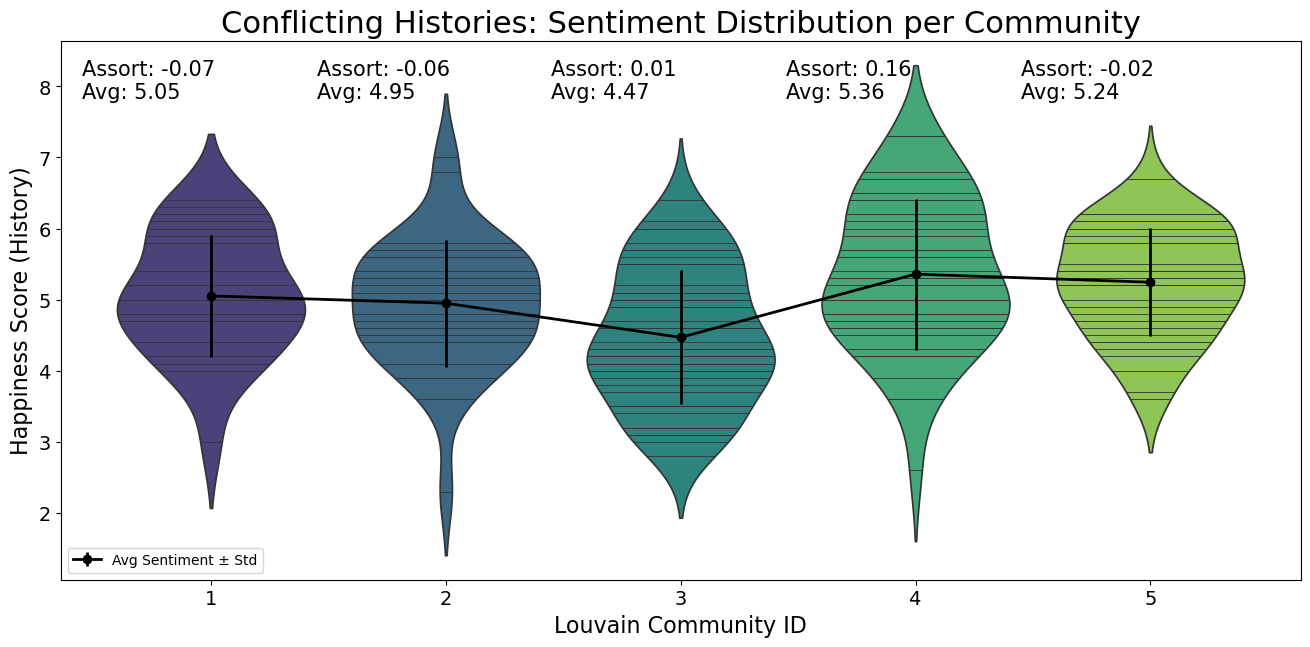

In [23]:
# 1. Create a DataFrame combining Communities and Sentiment, Assortativity, and Avg Sentiment
data = []
community_stats = []

for community_id, community_nodes in enumerate(louvain_communities):
    sentiments = [G.nodes[node].get('sentiment_score') for node in community_nodes if G.nodes[node].get('sentiment_score') is not None]
    avg_sentiment = np.mean(sentiments) if sentiments else None
    std_sentiment = np.std(sentiments) if sentiments else None
    # Calculate assortativity for this community
    try:
        assortativity = nx.numeric_assortativity_coefficient(G.subgraph(community_nodes), 'sentiment_score')
    except ValueError:
        assortativity = None
    community_stats.append({'Community': community_id + 1, 'Assortativity': assortativity, 'Avg_Sentiment': avg_sentiment, 'Std_Sentiment': std_sentiment})
    for sentiment in sentiments:
        data.append({'Community': community_id + 1, 'Sentiment': sentiment})

df_analysis = pd.DataFrame(data)
df_stats = pd.DataFrame(community_stats)

# Calculate variance per community
conflict_ranking = df_analysis.groupby('Community')['Sentiment'].std().sort_values(ascending=False)
print("Most Conflicted Communities (by Sentiment Standard Deviation):")
print(conflict_ranking.head())

# 2. Visualize
plt.figure(figsize=(16, 7))
sns.violinplot(data=df_analysis, x='Community', y='Sentiment', inner="stick", palette="viridis")

# Overlay average sentiment as a line with whiskers for std
avg_sentiments = df_stats['Avg_Sentiment']
std_sentiments = df_stats['Std_Sentiment']
communities = df_stats['Community'] - 1

plt.errorbar(communities, avg_sentiments, yerr=std_sentiments, color='black', marker='o', linestyle='-', linewidth=2, label='Avg Sentiment ± Std')

# Overlay assortativity and avg sentiment as text
for idx, row in df_stats.iterrows():
    plt.text(row['Community']-1.55, 0.97*plt.ylim()[1], 
             f"Assort: {row['Assortativity']:.2f}\nAvg: {row['Avg_Sentiment']:.2f}", 
             ha='left', va='top', fontsize=15, color='black')

plt.title('Conflicting Histories: Sentiment Distribution per Community', fontsize=22)
plt.xlabel('Louvain Community ID', fontsize=16)
plt.ylabel('Happiness Score (History)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.show()

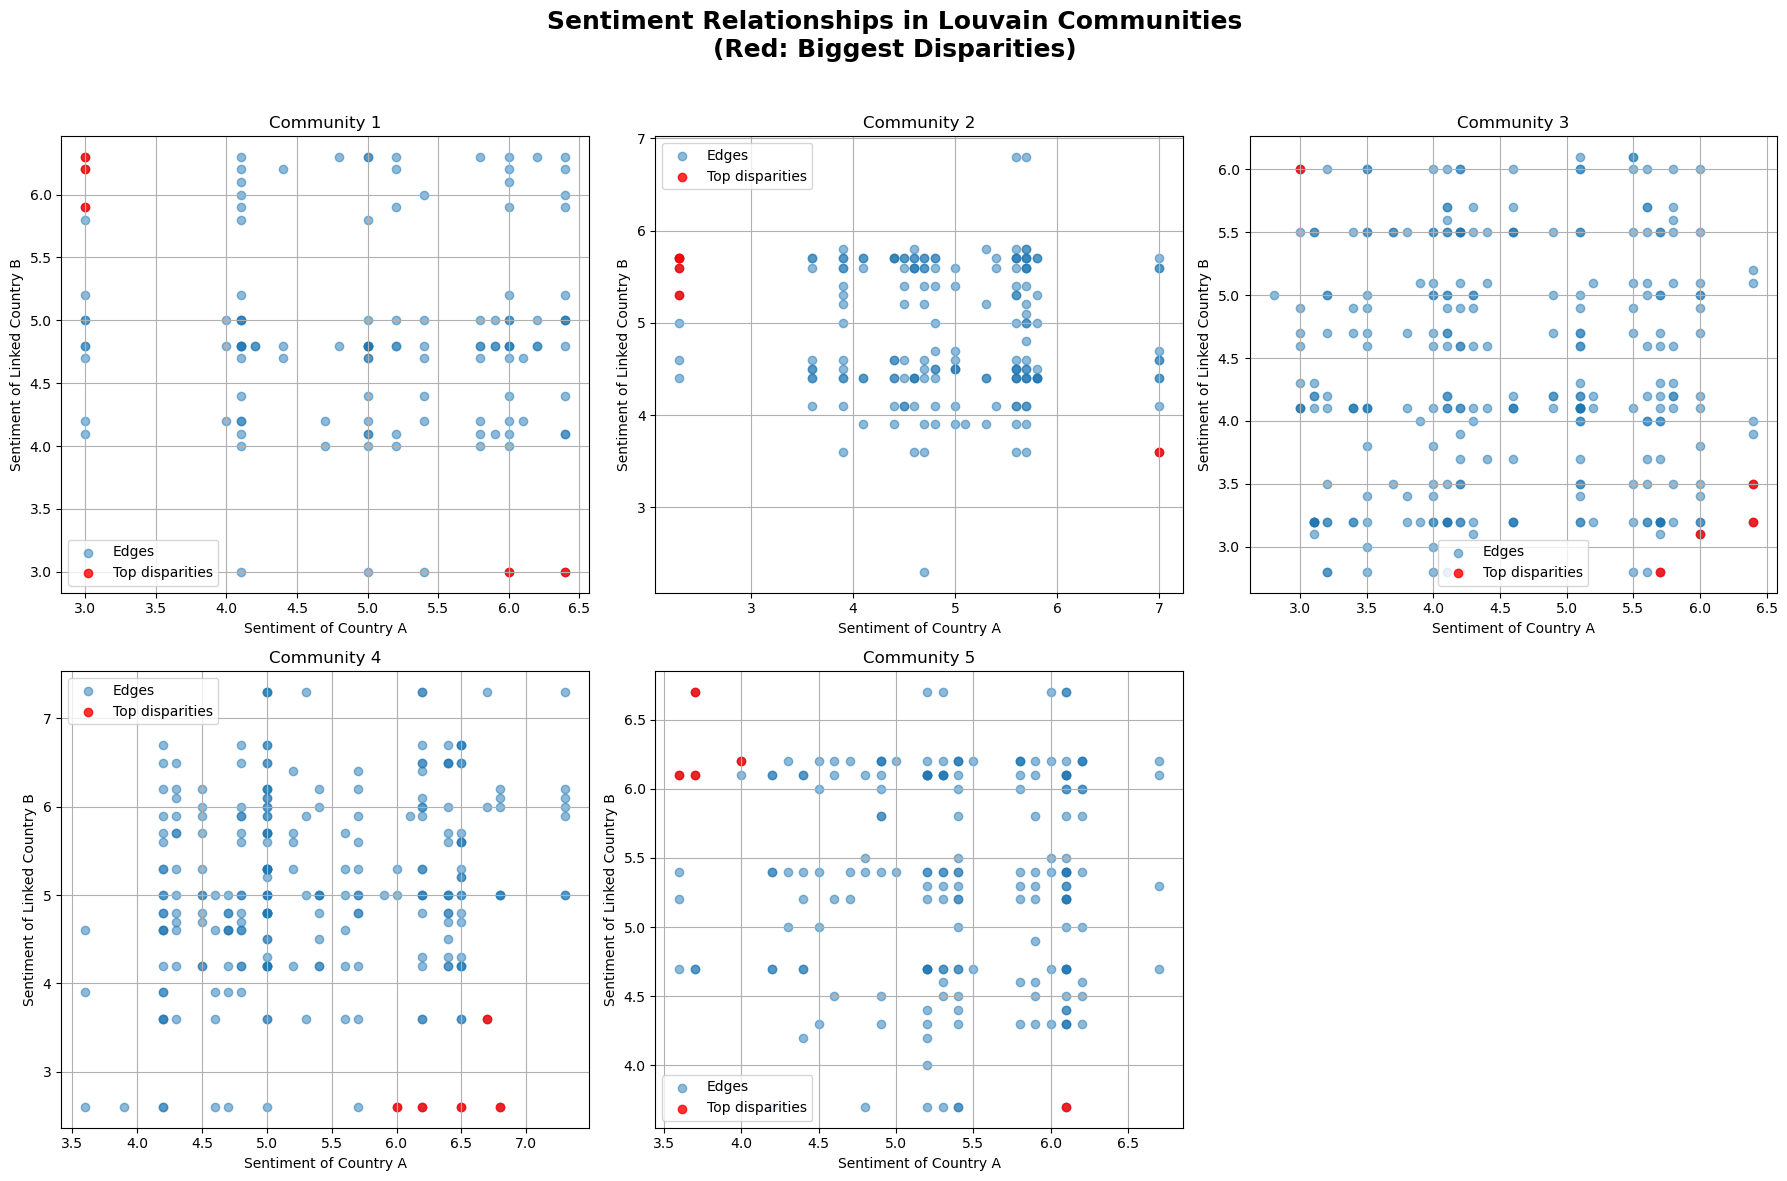

In [24]:
# Plot all communities' edge sentiment relationships in one figure
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

num_communities = len(louvain_communities)
for i in range(num_communities):
    nodes = louvain_communities[i]
    edge_x = []
    edge_y = []
    disparities = []
    subgraph = G.subgraph(nodes)
    for u, v in subgraph.edges():
        score_u = G.nodes[u].get('sentiment_score')
        score_v = G.nodes[v].get('sentiment_score')
        if score_u is not None and score_v is not None:
            edge_x.append(score_u)
            edge_y.append(score_v)
            disparities.append(abs(score_u - score_v))
    ax = axes[i]
    # Find indices of the top 5 biggest disparities
    if disparities:
        top_n = 5
        top_idx = np.argsort(disparities)[-top_n:]
        # Plot all points
        ax.scatter(np.array(edge_x), np.array(edge_y), alpha=0.5, label='Edges')
        # Overlay top disparities in red
        ax.scatter(np.array(edge_x)[top_idx], np.array(edge_y)[top_idx], color='red', alpha=0.8, label='Top disparities')
    else:
        ax.scatter([], [])
    ax.set_title(f'Community {i+1}')
    ax.set_xlabel('Sentiment of Country A')
    ax.set_ylabel('Sentiment of Linked Country B')
    ax.grid(True)
    ax.legend()

for j in range(num_communities, len(axes)):
    axes[j].axis("off")

fig.suptitle('Sentiment Relationships in Louvain Communities\n(Red: Biggest Disparities)', fontsize=18, weight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [25]:
# print countries in louvain community 2
print("Countries in Louvain Community 2:")
for country in louvain_communities[1]:
    print(country)

Countries in Louvain Community 2:
Uruguay
Costa_Rica
Argentina
Colombia
Brazil
Guatemala
Haiti
Saint_Vincent_and_the_Grenadines
Grenada
Spain
United_States
Trinidad_and_Tobago
Belize
Nicaragua
The_Bahamas
El_Salvador
Saint_Kitts_and_Nevis
Barbados
Cuba
Paraguay
Peru
Honduras
Venezuela
Mexico
Saint_Lucia
Ecuador
Andorra
Dominica
Dominican_Republic
Bolivia
Jamaica
Guyana
Panama
Chile


In [26]:
# Create a DataFrame of all extreme disparity pairs across all Louvain communities

SENTIMENT_DIFFERENCE_THRESHOLD = 1
all_extreme_pairs = []

for community_id, community_nodes in enumerate(louvain_communities, start=1):
    subgraph = G.subgraph(community_nodes)

    for u, v in subgraph.edges():
        score_u = G.nodes[u].get('sentiment_score')
        score_v = G.nodes[v].get('sentiment_score')
        cont_u = G.nodes[u].get('continent')
        cont_v = G.nodes[v].get('continent')

        # Step 1: Only consider edges between nodes on DIFFERENT continents
        if cont_u != cont_v:

            # Step 2: must have valid sentiment scores
            if score_u is not None and score_v is not None:

                # Step 3: Apply sentiment difference filter
                if abs(score_u - score_v) >= SENTIMENT_DIFFERENCE_THRESHOLD:

                    # Step 4: Assign happy vs sad
                    if score_u > score_v:
                        happy_country, happy_score = u, score_u
                        sad_country, sad_score = v, score_v
                    else:
                        happy_country, happy_score = v, score_v
                        sad_country, sad_score = u, score_u

                    all_extreme_pairs.append({
                        'Community_ID': community_id,
                        'Happy_Country': happy_country,
                        'Happy_Score': happy_score,
                        'Sad_Country': sad_country,
                        'Sad_Score': sad_score,
                        'Abs_Difference': abs(score_u - score_v)
                    })

# Combine into a DataFrame
df_disparity = pd.DataFrame(all_extreme_pairs)
df_disparity = df_disparity.sort_values(by='Abs_Difference', ascending=False)

# Save CSV
df_disparity.to_csv('data/extreme_sentiment_disparities_NEW.csv', index=False)

df_disparity


,Community_ID,Happy_Country,Happy_Score,Sad_Country,Sad_Score,Abs_Difference
101,4,Luxembourg,6.8,Afghanistan,2.6,4.2
97,4,Sweden,6.5,Afghanistan,2.6,3.9
103,4,Canada,6.2,Afghanistan,2.6,3.6
36,2,Spain,5.7,Haiti,2.3,3.4
113,4,Italy,6.0,Afghanistan,2.6,3.4
...,...,...,...,...,...,...
32,2,Mexico,5.7,Colombia,4.7,1.0
93,3,Portugal,6.0,Ethiopia,5.0,1.0
94,3,Portugal,6.0,São_Tomé_and_Príncipe,5.0,1.0
115,5,Australia,6.2,Indonesia,5.2,1.0


In [27]:
# Sankey diagram to visualize extreme sentiment disparities within communities
import plotly.graph_objects as go

def plot_sankey_disparities(df):
    # Prepare data for Sankey diagram
    labels = []
    source_indices = []
    target_indices = []
    values = []
    node_colors = []
    link_colors = []
    # List of countries to color differently
    special_countries = [
        "United_Kingdom", "France", "Spain", "Portugal", "Belgium", "Netherlands", "Germany", "Italy"
    ]
    # Assign colors
    special_color = "green"
    default_color = "blue"
    special_link_color = "rgba(60, 179, 113, 0.4)"  # semi-transparent green
    default_link_color = "lightblue"
    default_link_color = "lightblue"

    for _, row in df.iterrows():
        happy_label = f"{row['Happy_Country']} ({row['Happy_Score']})"
        sad_label = f"{row['Sad_Country']} ({row['Sad_Score']})"

        # Add happy country node
        if happy_label not in labels:
            labels.append(happy_label)
            country_name = row['Happy_Country']
            if country_name in special_countries:
                node_colors.append(special_color)
            else:
                node_colors.append(default_color)
        # Add sad country node
        if sad_label not in labels:
            labels.append(sad_label)
            country_name = row['Sad_Country']
            if country_name in special_countries:
                node_colors.append(special_color)
            else:
                node_colors.append(default_color)

        source_idx = labels.index(happy_label)
        target_idx = labels.index(sad_label)

        source_indices.append(source_idx)
        target_indices.append(target_idx)
        values.append(row['Abs_Difference'])

        # If either country is special, color the link as special
        if row['Happy_Country'] in special_countries or row['Sad_Country'] in special_countries:
            link_colors.append(special_link_color)
        else:
            link_colors.append(default_link_color)

    # Create Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color=node_colors
        ),
        link=dict(
            source=source_indices,
            target=target_indices,
            value=values,
            color=link_colors
        )
    )])

    fig.update_layout(
        title_text="Extreme Sentiment Disparities",
        font_size=20,
        width=1000,
        height=800
    )

    # Save as jpg
    fig.show()


# Plot the Sankey diagram for extreme sentiment disparities
plot_sankey_disparities(df_disparity)

In [28]:
# Filter only top most connected countries for clarity
df_subgraph = df_disparity.head(25)  # Top 30 extreme disparities

# SANKEY
plot_sankey_disparities(df_subgraph)


---

Results of TF-IDF are not making much sense right now. I believe considering GDP per capita will result in a better behaviour. 

# TF-IDF 

In [66]:
import os
import math
import random
import string
from pathlib import Path
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


## New TF-IDF

In [67]:
df_disparity = pd.read_csv('data/extreme_sentiment_disparities.csv')
happy_countries = list(set(df_disparity['Happy_Country']))
sad_countries = list(set(df_disparity['Sad_Country']))

In [68]:
def build_happy_sad_texts(folder_path, happy_countries, sad_countries):
    """
    Loads country .txt files from folder_path, merges them into two big happy and sad texts.
    
    Parameters:
    folder_path: str or Path
        Folder where all country .txt files are stored.
    happy_countries: list[str]
        List of country names belonging to the high-sentiment group.
    sad_countries: list[str]
        List of country names belonging to the low-sentiment group.

    Returns:
    happy_text: str
        Merged text of all happy countries.
    sad_text: str
        Merged text of all sad countries.
    """

    folder_path = Path(folder_path)

    # Helper function to load and concatenate
    def merge_texts(country_list):
        combined = []
        for country in country_list:
            filename = country.lower().replace(" ", "_") + ".txt"
            file_path = folder_path / filename

            if file_path.exists():
                combined.append(file_path.read_text(encoding="utf-8"))
            else:
                print(f"WARNING: missing file: {filename}")

        return "\n".join(combined)

    # Build the texts
    happy_text = merge_texts(happy_countries)
    sad_text   = merge_texts(sad_countries)

    # Save them 
    (folder_path / "happy_all.txt").write_text(happy_text, encoding="utf-8")
    (folder_path / "sad_all.txt").write_text(sad_text, encoding="utf-8")

    return happy_text, sad_text

In [69]:
# Build happy and sad texts
happy_text, sad_text = build_happy_sad_texts("countries_cleaned_plus_nationalities", happy_countries, sad_countries)

In [ ]:
# Tokenization and cleaning
happy_tokens = clean_tokenize(happy_text)
sad_tokens   = clean_tokenize(sad_text)

NameError: name 'clean_tokenize' is not defined

In [ ]:
# Compute TF
tf_happy = Counter(happy_tokens)
tf_sad   = Counter(sad_tokens)
num_happy_tokens = len(happy_tokens)
num_sad_tokens   = len(sad_tokens)

# Compute IDF
vocab = set(tf_happy) | set(tf_sad)
df = {w: int(w in tf_happy) + int(w in tf_sad) for w in vocab}
N_docs = 2
idf = {w: math.log((N_docs + 1) / (df[w] + 1)) for w in vocab}

# Compute TF-IDF
tfidf_happy = {w: ((tf_happy[w]/num_happy_tokens) * idf[w]) for w in tf_happy}
tfidf_sad   = {w: ((tf_sad[w]/num_sad_tokens) * idf[w]) for w in tf_sad}

In [ ]:
top_h = sorted(tfidf_happy.items(), key=lambda x: x[1], reverse=True)[:10]
top_s = sorted(tfidf_sad.items(),   key=lambda x: x[1], reverse=True)[:10]

words_h, scores_h = zip(*top_h)
words_s, scores_s = zip(*top_s)

In [71]:
df_happy_tfidf = pd.DataFrame({'Word': words_h, 'TF-IDF': scores_h})
df_sad_tfidf   = pd.DataFrame({'Word': words_s, 'TF-IDF': scores_s})

NameError: name 'words_h' is not defined

In [72]:
df_happy_tfidf

NameError: name 'df_happy_tfidf' is not defined

In [73]:
df_sad_tfidf

NameError: name 'df_sad_tfidf' is not defined

To better visualized the results, we will now plot the bar plots and the wordclouds for the high and low sentiment countries.

In [74]:
# Sort TF-IDF so top term is closest to the x-axis
top_h = sorted(tfidf_happy.items(), key=lambda x: x[1])[-10:]
top_s = sorted(tfidf_sad.items(),   key=lambda x: x[1])[-10:]

words_h, scores_h = zip(*top_h)
words_s, scores_s = zip(*top_s)

# Frequencies for wordclouds
freqs_h = dict(tfidf_happy)
freqs_s = dict(tfidf_sad)


# Wordclouds 
wc_h = WordCloud(
    width=900, height=500, background_color="white",
    colormap="cool",   
    prefer_horizontal=1
).generate_from_frequencies(freqs_h)

wc_s = WordCloud(
    width=900, height=500, background_color="white",
    colormap="autumn_r",  
    prefer_horizontal=1
).generate_from_frequencies(freqs_s)


# Figure layout
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(18, 16))

# Column titles
axes[0,0].set_title("High-sentiment countries", fontsize=22, fontweight="bold", pad=20)
axes[0,1].set_title("Low-sentiment countries",  fontsize=22, fontweight="bold", pad=20)

# Barplot styling
bar_color_h = sns.color_palette("cool", 10)[4]     
bar_color_s = sns.color_palette("autumn_r", 10)[3] 


# High sentiment countries barplot 
sns.barplot(
    x=list(scores_h), 
    y=list(words_h),
    ax=axes[0,0], 
    color=bar_color_h,
    edgecolor="black"
)
axes[0,0].set_xlabel("TF-IDF", fontsize=17)
axes[0,0].set_ylabel("")
axes[0,0].tick_params(axis="y", labelsize=17)  
axes[0,0].tick_params(axis="x", labelsize=14)


# Low sentiment countries barplot
sns.barplot(
    x=list(scores_s), 
    y=list(words_s),
    ax=axes[0,1], 
    color=bar_color_s,
    edgecolor="black"
)
axes[0,1].set_xlabel("TF-IDF", fontsize=17)
axes[0,1].set_ylabel("")
axes[0,1].tick_params(axis="y", labelsize=17)
axes[0,1].tick_params(axis="x", labelsize=14)


# Center everything
axes[1,0].imshow(wc_h, interpolation="bilinear")
axes[1,0].axis("off")

axes[1,1].imshow(wc_s, interpolation="bilinear")
axes[1,1].axis("off")

# Final layout 
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

NameError: name 'tfidf_happy' is not defined

This function will be used to eliminate the countries names from the countries wikipages. We will also try to eliminate nationalities. 

In [75]:
countries = list(G.nodes())

In [76]:
NATIONALITIES = [
    "Afghan", "Albanian", "Algerian", "American", "Andorran", "Angolan",
    "Antiguan", "Argentine", "Armenian", "Australian", "Austrian",
    "Azerbaijani", "Bahamian", "Bahraini", "Bangladeshi", "Barbadian",
    "Belarusian", "Belgian", "Belizean", "Beninese", "Bhutanese",
    "Bolivian", "Bosnian", "Botswanan", "Brazilian", "British", "Bruneian",
    "Bulgarian", "Burkinabe", "Burmese", "Burundian", "Cambodian",
    "Cameroonian", "Canadian", "Cape Verdean", "Central African",
    "Chadian", "Chilean", "Chinese", "Colombian", "Comorian",
    "Congolese", "Costa Rican", "Croatian", "Cuban", "Cypriot",
    "Czech", "Danish", "Djiboutian", "Dominican", "Dutch",
    "East Timorese", "Ecuadorian", "Ecuadorean",
    "Egyptian", "Emirati", "English", "Equatoguinean",
    "Eritrean", "Estonian", "Ethiopian", "Fijian", "Filipino",
    "Philippine", 
    "Finnish", "French", "Gabonese", "Gambian", "Georgian", "German",
    "Ghanaian", "Greek", "Grenadian", "Guatemalan", "Guinean",
    "Guyanese", "Haitian", "Honduran", "Hungarian", "Icelandic",
    "Indian", "Indonesian", "Iranian", "Iraqi", "Irish",
    "Israeli", "Italian", "Jamaican", "Japanese", "Jordanian",
    "Kazakh", "Kenyan", "Kiribati", "Kittitian", "Korean", "Kosovar",
    "Kuwaiti", "Kyrgyz", "Lao", "Latvian", "Lebanese", "Liberian",
    "Libyan", "Liechtensteiner", "Lithuanian", "Luxembourger", "Luxembourgish",
    "Macedonian", 
    "Malagasy", "Malawian", "Malaysian", "Maldivian", "Malian",
    "Maltese", "Marshallese", "Mauritanian", "Mauritian", "Mexican",
    "Micronesian", "Moldovan", "Monacan", "Mongolian", "Montenegrin",
    "Moroccan", "Mozambican", "Namibian", "Nauruan", "Nepalese",
    "New Zealander", "Nicaraguan", "Nigerian", "Nigerien", "Niuean",
    "Norwegian", "Omani", "Pakistani", "Palauan", "Palestinian", "Panamanian",
    "Papua New Guinean", "Paraguayan", "Peruvian", "Polish",
    "Portuguese", "Qatari", "Romanian", "Russian", "Rwandan",
    "Salvadoran", "Sammarinese", "Samoan", "Saudi", "Scottish",
    "Senegalese", "Serbian", "Seychellois", "Sierra Leonean",
    "Singaporean", "Slovak", "Slovenian", "Slovene", 
    "Somali", "South African", "South Sudanese", "Spanish",
    "Sri Lankan", "Sudanese", "Surinamese", "Swazi", "Swedish",
    "Swiss", "Syrian", "Taiwanese", "Tajik", "Tanzanian", "Thai",
    "Togolese", "Tongan", "Trinidadian", "Tunisian", "Turkish",
    "Turkmen", "Tuvaluan", "Ugandan", "Ukrainian", "Uruguayan",
    "Uzbek", "Vanuatuan", "Venezuelan", "Vietnamese", "Welsh",
    "Yemeni", "Zambian", "Zimbabwean",
    "Czechoslovakian", "Transjordanian", "Burman", "Burmese",
]

EXTRA_COUNTRIES = [
    "Burma",
    "Macedonia",
    "Czechoslovakia",
    "Transjordan",
    "Nubia",
    "Anatolia",
    "Bosnia",
    "Bahamas",
    "Trinidad",
    "Tobago",
    "Herzegovina",
    "Congo",
    "Saint",
    "Vincent",
    "Grenadines",
    "Korea",
    "Palestine",
    "Macedonia", 
    "Timor", 
    "São Tomé",
]

EXTRA_TERMS = ["url"]

country_list = countries + EXTRA_COUNTRIES + EXTRA_TERMS



In [77]:

def clean_countries_and_nationalities(
    source_folder,
    dest_folder,
    country_list,
    nationalities
):
    source = Path(source_folder)
    dest = Path(dest_folder)
    dest.mkdir(parents=True, exist_ok=True)

    # Prepare country names 
    cleaned_countries = [
        c.replace("_", " ").title() for c in country_list
    ]

    country_terms = []

    for c in cleaned_countries:
        country_terms.append(c)          
        country_terms.append(c.lower())  
        country_terms.append(c + "s")        
        country_terms.append(c.lower() + "s")  

    # Prepare nationalities 
    nationality_terms = []

    for nat in nationalities:
        singular_title = nat
        singular_lower = nat.lower()
        plural_title = nat + "s"
        plural_title = nat + "es"
        plural_lower = nat.lower() + "s"

        nationality_terms.extend([
            singular_title,
            singular_lower,
            plural_title,
            plural_lower,
        ])


    # Build final regex
    all_terms = country_terms + nationality_terms

    # Escape and join terms
    pattern = re.compile(
        r"\b(" + "|".join(map(re.escape, all_terms)) + r")\b",
        flags=re.IGNORECASE
    )

    # Process files
    for file in source.glob("*.txt"):
        text = file.read_text(encoding="utf-8")
        cleaned = pattern.sub("", text)
        (dest / file.name).write_text(cleaned, encoding="utf-8")


In [78]:
clean_countries_and_nationalities(
    source_folder="countries_pages",
    dest_folder="countries_cleaned_plus_nationalities",
    country_list=country_list,
    nationalities=NATIONALITIES,
)

In [79]:
#new_t = clean_tokenize("coup d'état, coup d'état, coup d'état, coup d'état" )
new_t = clean_tokenize(" coup d'état, coup d'état, coup d'état, coup d'état coup d'état, coup d'état, coup d'état, coup d'état" )

new_t

NameError: name 'clean_tokenize' is not defined

Now we will start with the TF-IDF functions. 

In [ ]:
# initialize the list of common English stopwords and a lemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
import regex


def clean_tokenize(text, rare_threshold=4):
    """
    Clean, tokenize, and lemmatize a text string. Produces unigram and bigram tokens.
    - Lowercase
    - Remove punctuation and numbers
    - Remove stopwords
    - Lemmatize words
    - Filter out rare words considering all the texts (freq < rare_threshold)

    Parameters:
    text: str
        Text being clean 
    rare_threshold: int
        Minimum number of times a word needs to appear in a text to be considered

    Returns
    tokens : list of str
        List of cleaned, lemmatized tokens that occur at least
        'rare_threshold' times in the all the texts.
    """

    # lowercase
    text = text.lower()

    # remove wiki markup, references, templates
    text = re.sub(r"\{\{.*?\}\}", " ", text, flags=re.DOTALL)
    text = re.sub(r"<ref.*?>.*?</ref>", " ", text, flags=re.DOTALL)
    text = re.sub(r"<ref.*?/>", " ", text)
    text = text.replace("[", " ").replace("]", " ")

    # normalize apostrophes and remove them
    text = text.replace("’", "'").replace("‘", "'").replace("´", "'").replace("`", "'")
    text = re.sub(r"'", "", text)

    # remove punctuation and numbers
    text = regex.sub(r"[^\p{L}_]+", " ", text)

    # tokenize (split on whitespace)
    tokens = text.split()

    # lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    # remove stopwords
    tokens = [t for t in tokens if t not in stop_words]

    # remove very short tokens
    tokens = [t for t in tokens if len(t) > 2]

    # build bigrams
    bigrams = [tokens[i] + "_" + tokens[i+1] for i in range(len(tokens)-1)]

    # filter rare words based on frequencies in this text
    freq = Counter(bigrams)
    bigrams = [bg for bg in bigrams if freq[bg] >= rare_threshold]
    
    return bigrams


def compute_tf_for_communities(base_path, communities, out_folder, prefix="community"):
    """
    Compute term-frequency lists (TF) for a set of communities.

    Parameters  
    base_path : Path
        Folder with artist text files (.txt)
    communities : dict or list
        - If dict: {community_name: [artists]}
        - If list: [set(artists), set(artists), ...]
    out_folder : Path
        Output folder to store TF files
    prefix : str
        Prefix for naming files (e.g. 'primary', 'random', 'louvain')

    Returns
    genre_texts : dict
        Dictionary mapping each community name to a 'Counter' object containing
        the term frequencies of that community.
    """
    out_folder.mkdir(exist_ok=True)
    genre_texts = defaultdict(list)

    # normalize to dict form for convenience
    if isinstance(communities, list):
        communities = {f"{prefix}_{i+1}": list(c) for i, c in enumerate(communities)}

    # tokenize 
    for name, countries in communities.items():
        combined_tokens = []
        for artist in countries:
            file_path = base_path / f"{artist.replace(' ', '_').lower()}.txt"
            text = file_path.read_text(encoding="utf-8")
            tokens = clean_tokenize(text)
            combined_tokens.extend(tokens)

        # compute and save TF for this community
        counts = Counter(combined_tokens)
        genre_texts[name] = counts

        # store TF lists
        if prefix== "louvain":
            out_file = out_folder / f"{name}_TF.txt"
        else:
            out_file = out_folder / f"{prefix}_{name}_TF.txt"
            
        with open(out_file, "w", encoding="utf-8") as f:
            for word, count in counts.most_common():
                f.write(f"{word} {count}\n")

    return genre_texts

In [ ]:
def compute_tfidf(group_folder, label_type, top_n=10):
    """
    Compute TF-IDF for each group/community from the files containing the TF lists.

    Parameters
    group_folder : str or Path
        Path to the folder containing the TF lists files for each group or community.
    label_type : str
        Label indicating the type of grouping ("primary", "random", or "louvain"),
        used for formatting the printed output.
    top_n : int, optional
        Number of top words to display for each group based on TF-IDF score.
        Default is 10.

    Returns
    group_tfidf : dict
        Dictionary mapping each group name to a dictionary of {word: TF-IDF value}.
        
    """
    group_folder = Path(group_folder)
    group_tf = {}
    all_words = set()

    # load TF lists 
    for file in group_folder.glob("*_TF.txt"):
        name = file.stem  

        #  remove prefix
        for prefix in ["sentiment_score", "gdp_", "louvain_", "continent_"]:
            if name.lower().startswith(prefix):
                prefix_removed = name[len(prefix):]
                detected_prefix = prefix  
                break

        # remove "_TF"
        prefix_removed = prefix_removed[:-3]

        # clean up spacing and capitalization
        clean_name = prefix_removed.strip().upper()

        # store words and frequencies
        counts = Counter()
        with open(file, "r", encoding="utf-8") as f:
            for line in f:
                    word, freq = line.strip().split()
                    freq = int(freq)
                    counts[word] = freq
                    all_words.add(word)
        group_tf[clean_name] = counts

    # compute DF 
    df = Counter()
    for word in all_words:
        df[word] = sum(1 for tf_counts in group_tf.values() if word in tf_counts)

    # compute IDF 
    N = len(group_tf)
    idf = {word: math.log((N + 1) / (df[word] + 1)) for word in all_words}

    # compute TF-IDF 
    group_tfidf = {}
    for group_name, tf_counts in group_tf.items():
        total_words = sum(tf_counts.values())
        tfidf = {word: (count / total_words) * idf[word] for word, count in tf_counts.items()}
        group_tfidf[group_name] = tfidf

    # print the results
    for group_name, tfidf_dict in group_tfidf.items():
        if "louvain" in label_type.lower():
            print(f"\n=== Top {top_n} TF-IDF words for Louvain community {group_name.replace('_', ' ')} ===")
        elif "continent" in label_type.lower():
            print(f"\n=== Top {top_n} TF-IDF words for continent {group_name.replace('_', ' ')} ===")
        elif 'gdp' in label_type.lower():
            print(f"\n=== Top {top_n} TF-IDF words for the {detected_prefix.replace('_', ' ').upper()}attribute: {group_name.replace('_', ' ').title()} ===")
        else: 
            print(f"\n=== Top {top_n} TF-IDF words for the {detected_prefix.replace('_', ' ')} attribute: {group_name.replace('_', ' ').title()} ===")
        top_items = sorted(tfidf_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
        for word, score in top_items:
            print(f"{word:<20s} {score:>10.6f}")

    return group_tfidf


In [ ]:
# Path to the folder containing the text from each Wikipedia page 
base_path = Path("countries_cleaned_plus_nationalities")

In [ ]:
# TF lists considering the sentiment score 
tf_sentiment = compute_tf_for_communities(base_path, sentiment_partitions, Path("Sentiment_TF"), prefix="sentiment_score")

# TF lists considering the GDP level
tf_gdp = compute_tf_for_communities(base_path, gdp_partitions, Path("GDP_TF"), prefix="gdp")

# TF lists considering the continent
tf_continent = compute_tf_for_communities(base_path, continent_communities, Path("Continent_TF"), prefix="continent")

# TF lists for the Louvain communities
tf_louvain = compute_tf_for_communities(base_path, louvain_communities, Path("Louvain_TF"), prefix="louvain")

In [ ]:
# TF-IDF considering levels of GDP
tfidf_gdp = compute_tfidf("GDP_TF", label_type="GDP Level")

In [ ]:
# TF-IDF considering sentiment scores
tfidf_sentiment = compute_tfidf("Sentiment_TF", label_type="Sentiment Score")

In [ ]:
# TF-IDF considering louvain communities
tfidf_louvain = compute_tfidf("Louvain_TF", label_type="Louvain")

In [ ]:
# TF-IDF considering continent communities
tfidf_continent = compute_tfidf("Continent_TF", label_type="Continent")

We will now try to look for bigrams as well in our TF-IDF analysis. I think it could be good to include the analysis together and then separate, especially of the bigrams, bacause it can show some nice results. 

### Visualization

In [ ]:
def plot_tfidf_bars(group_tfidf, label_type, save_path=None):
    """
    Create bar plots showing the top TF-IDF words for selected groups or communities.

    Parameters
    group_tfidf : dict
        Dictionary mapping each group name to a dictionary of words and
        their corresponding TF-IDF values.    
    label_type : str
        Type of community/genre attribution used in the analysis.
        Used in the figure title.
    top_n : int, optional
        Number of top words to display for each group. Default is 10.
    save_path : str or Path, optional
        File path to save the resulting figure. If not provided, the plot is shown
        interactively instead.

    Returns
    None
    """

    # Format Community Names
    def format_group_name(name):
        name = name.replace("_", " ")       
        name = name.title()                  
        return name
    
    # Prepare plotting data 
    rows = []
    for group, scores in group_tfidf.items():
        top_items = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
        for word, score in top_items:
            rows.append((format_group_name(group), word, score))
    df = pd.DataFrame(rows, columns=["Group", "Word", "TF-IDF"])

    # Determine grid layout
    n_groups = df["Group"].nunique()
    n_cols = min(4, n_groups)
    n_rows = math.ceil(n_groups / n_cols)

    # Create subplots grid 
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 6 * n_rows), sharey=False)
    axes = axes.flatten() if n_groups > 1 else [axes]

    # Plot each group 
    palette = sns.color_palette("Set2", n_groups)
    for ax, (group, subdf), color in zip(axes, df.groupby("Group"), palette):
        sns.barplot(
            data=subdf,
            y="Word",
            x="TF-IDF",
            ax=ax,
            color=color
        )
        ax.set_title(group, fontsize=13, weight="bold")
        ax.set_xlabel("TF-IDF score", fontsize=11)
        ax.set_ylabel("")
        ax.invert_yaxis()
        sns.despine(ax=ax)
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
        ax.xaxis.get_offset_text().set_fontsize(10)

    # Hide unused axes 
    for j in range(len(df["Group"].unique()), len(axes)):
        axes[j].set_visible(False)

    # Figure title and layout 
    fig.suptitle(f"Top {top_n} TF-IDF Words considering {label_type}",
                 fontsize=16, weight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Save or show 
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    else:
        plt.show()

In [ ]:
plot_tfidf_bars(tfidf_gdp, label_type="GDP Level", save_path="plots/tfidf_gdp.png")

In [ ]:
plot_tfidf_bars(tfidf_sentiment, label_type="Sentiment Score Level", save_path="plots/tfidf_sentiment.png")

In [ ]:
plot_tfidf_bars(tfidf_louvain, label_type="Louvain Communities", save_path="plots/tfidf_louvain.png")


In [ ]:
plot_tfidf_bars(tfidf_continent, label_type="the Continent", save_path="plots/tfidf_continent.png")


Now, we will use another plotting function to compare the tf-idf from specific partitions inside them.

In [ ]:
#Prepare the tfidf of the different communities to be ploted together 
all_group_tfidf = {}
all_group_tfidf.update(tfidf_gdp)
all_group_tfidf.update(tfidf_sentiment)
all_group_tfidf.update(tfidf_continent)
all_group_tfidf.update(tfidf_louvain)

In [ ]:
def plot_selected_tfidf_groups(group_tfidf, groups_to_plot, top_n=10, title=None, save_path=None):
    """
    Plot TF-IDF bar charts for a selected subset of groups/communities/genres.

    Parameters
    group_tfidf : dict
        { group_name : {word: tfidf_score, ...}, ... }
    groups_to_plot : list of str
        Names of groups to include in the comparison plot.
        Must match keys in group_tfidf.
    top_n : int, optional
        Number of top TF-IDF words to show for each group.
    title : str, optional
        Title for the full figure.
    save_path : str or Path, optional
        If provided, saves the figure. Otherwise displays it.

    Returns
    None
    """

    # Format group names for nicer plot titles
    def format_group_name(name):
        return name.replace("_", " ").title()

    valid_groups = [g for g in groups_to_plot if g in group_tfidf]

    # Build a DataFrame of the selected groups
    rows = []
    for group in valid_groups:
        scores = group_tfidf[group]
        top_items = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]

        for word, score in top_items:
            rows.append((format_group_name(group), word, score))

    df = pd.DataFrame(rows, columns=["Group", "Word", "TF-IDF"])

    # Grid configuration 
    n_groups = len(df["Group"].unique())
    n_cols = min(4, n_groups)
    n_rows = math.ceil(n_groups / n_cols)

    fig, axes = plt.subplots(
        n_rows, n_cols, 
        figsize=(5 * n_cols, 6 * n_rows), 
        sharey=False
    )

    axes = axes.flatten() if n_groups > 1 else [axes]

    # Plot each group
    palette = sns.color_palette("Set2", n_groups)

    for ax, (group, subdf), color in zip(axes, df.groupby("Group"), palette):
        sns.barplot(
            data=subdf,
            y="Word",
            x="TF-IDF",
            ax=ax,
            color=color
        )
        ax.set_title(group, fontsize=13, weight="bold")
        ax.set_xlabel("TF-IDF score", fontsize=11)
        ax.set_ylabel("")
        ax.invert_yaxis()
        sns.despine(ax=ax)
        ax.ticklabel_format(style="sci", axis="x", scilimits=(0, 0))
        ax.xaxis.get_offset_text().set_fontsize(10)

    # Hide unused axes 
    for j in range(len(df["Group"].unique()), len(axes)):
        axes[j].set_visible(False)

    # Global title 
    if title:
        fig.suptitle(title, fontsize=16, weight="bold")
    else:
        fig.suptitle("TF-IDF Comparison", fontsize=16, weight="bold")

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Save or show 
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    else:
        plt.show()


In [ ]:
interest_groups = [""]

### Word-Clouds

In [ ]:
def create_wordclouds(group_tfidf, out_folder, max_words=100):
    """
    Create and save word clouds for each community/group based on TF-IDF scores.

    Parameters
    group_tfidf : dict
        Dict from compute_tfidf(): {group_name: {word: tfidf_value}}
    out_folder : str or Path
        Folder where the PNG files will be saved
    max_words : int
        Maximum number of words in each word cloud

    Returns
    None
    """
    out_folder = Path(out_folder)
    out_folder.mkdir(exist_ok=True)

    for group_name, tfidf_scores in group_tfidf.items():
        if not tfidf_scores:
            continue

        # Normalize values (to help visual scaling)
        max_val = max(tfidf_scores.values())
        freqs = {word: score / max_val for word, score in tfidf_scores.items()}

        # Create world-cloud 
        wc = WordCloud(
            width=1200,
            height=800,
            background_color="white",
            max_words=max_words,
            colormap="viridis",
            random_state=42
        ).generate_from_frequencies(freqs)

        # Save figure
        plt.figure(figsize=(10, 6))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        out_path = out_folder / f"{group_name}_wordcloud.png"
        plt.tight_layout()
        plt.savefig(out_path, dpi=300)
        plt.close()

In [ ]:
create_wordclouds(tfidf_gdp, "wordclouds_gdp_level")

In [ ]:
create_wordclouds(tfidf_sentiment, "wordclouds_sentiment_score_level")

In [ ]:
create_wordclouds(tfidf_louvain, "wordclouds_louvain")

In [ ]:
create_wordclouds(tfidf_continent, "wordclouds_continent")

In [ ]:
# image paths 
img1 = Path("wordclouds_gdp_level\LEVEL_1_wordcloud.png")     
img2 = Path("wordclouds_louvain/1_wordcloud.png")      

titles = [ "GDP Level 1", "Community 1"]

# Plot them side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

for ax, img_path, title in zip(axes, [img1, img2], titles):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(title, fontsize=16, weight="bold")

plt.tight_layout()
plt.show()